In [1]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.3.0


# Set up OpenAQ, Meteostat APIs
OpenAQ: https://openaq.org/ MeteoStat: https://meteostat.net/en

Tools py-openaq: https://github.com/dhhagan/py-openaq meteostat: https://dev.meteostat.net/python/

In [2]:
import openaq
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_IT = []

cities = openaq.cities(country="IT", limit=100000, df=True)["city"]

for city in cities:
    print(city) 
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_IT.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))

Alessandria
ALFONSINE
Ancona
Arezzo
Ascoli Piceno
Asti
Avellino
Bari
Barletta-Andria-Trani
Belluno
Benevento
Bergamo
Biella
Bologna
BOLOGNA
Bolzano/Bozen
Brescia
Brindisi
Cagliari
Campobasso
Carbonia-Iglesias
CARPI
Caserta
Catanzaro
CENTO
CESENA
Chiesanuova
Civitavecchia
COLORNO
Como
Cosenza
Cremona
Crotone
Cuneo
FAENZA
Ferrara
FERRARA
FIORANO MODENESE
Firenze
Foggia
FORLI'
Forli'-Cesena
Frosinone
Genova
Grosseto
GUASTALLA
IMOLA
JOLANDA DI SAVOIA
LANGHIRANO
L'Aquila
Latina
Lecce
Lecco
Livorno
Lodi
Lucca
LUGAGNANO VAL D'ARDA
Macerata
Mantova
Massa-Carrara
Matera
MEZZANI
Milano
MIRANDOLA
Modena
MODENA
MOLINELLA
Monza E Della Brianza
Napoli
Novara
Nuoro
Olbia-Tempio
Oristano
OSTELLATO
Padova
Parma
PARMA
Pavia
Perugia
Pesaro E Urbino
Pescara
Piacenza
PIACENZA
Pisa
Pistoia
PORRETTA TERME
Potenza
Prato
Ravenna
RAVENNA
Reggio Di Calabria
Reggio Nell'Emilia
REGGIO NELL'EMILIA
Rieti
Rimini
RIMINI
Roma
Rovigo
Salerno
SAN CLEMENTE
SAN LAZZARO DI SAVENA
SAN LEO
Sassari
SASSUOLO
SAVIGNANO SUL RUBIC

In [3]:
from datetime import datetime, timedelta
import time

# Napoli index 68
# Trento index 113

# Select Napoli because it holds most sensors and less holes
selected_location = locations_IT[68]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2','co']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

Napoli
Time Range: 2020-05-10 00:00:00 - 2021-10-02 00:00:00
Added location 8410
Added location 8444
Added pollutant pm25
---------------------
Added location 8410
Added location 8411
Added location 8444
Added pollutant pm10
---------------------
Added location 8409
Added location 8410
Added location 8411
Added location 8444
Added location 8597
Added location 8408
Added pollutant no2
---------------------
Added location 8408
Added pollutant o3
---------------------
Added location 8410
Added location 8411
Added pollutant so2
---------------------
Added location 8410
Added location 8411
Added location 8444
Added location 8408
Added pollutant co
---------------------
Data fetching completed!


pm25       pm10        no2     o3    so2     co
date.local                                                           
2020-05-10 02:00:00  13.60  27.000000  47.531667  61.76  0.605  572.5
2020-05-10 03:00:00   9.50  22.833333  51.863333  21.06  0.670  490.0
2020-05-10 04:00:00  16.65  22.500000  44.445000  32.12  0.660  480.0
2020-05-10 05:00:00  15.30  23.600000  38.851667  25.20  0.360  482.5
2020-05-10 06:00:00  18.65  27.066667  31.305000  31.32  0.820  477.5
...                    ...        ...        ...    ...    ...    ...
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.60  4.180  690.0
2021-10-01 23:00:00  21.75  34.200000  63.921667    NaN  3.460  750.0
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.29  3.335  650.0
2021-10-02 01:00:00  24.05  38.966667  51.535000  21.14  3.995  562.5
2021-10-02 02:00:00  21.05  39.166667  52.080000  19.27  3.595  557.5

[12241 rows x 6 columns]

array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

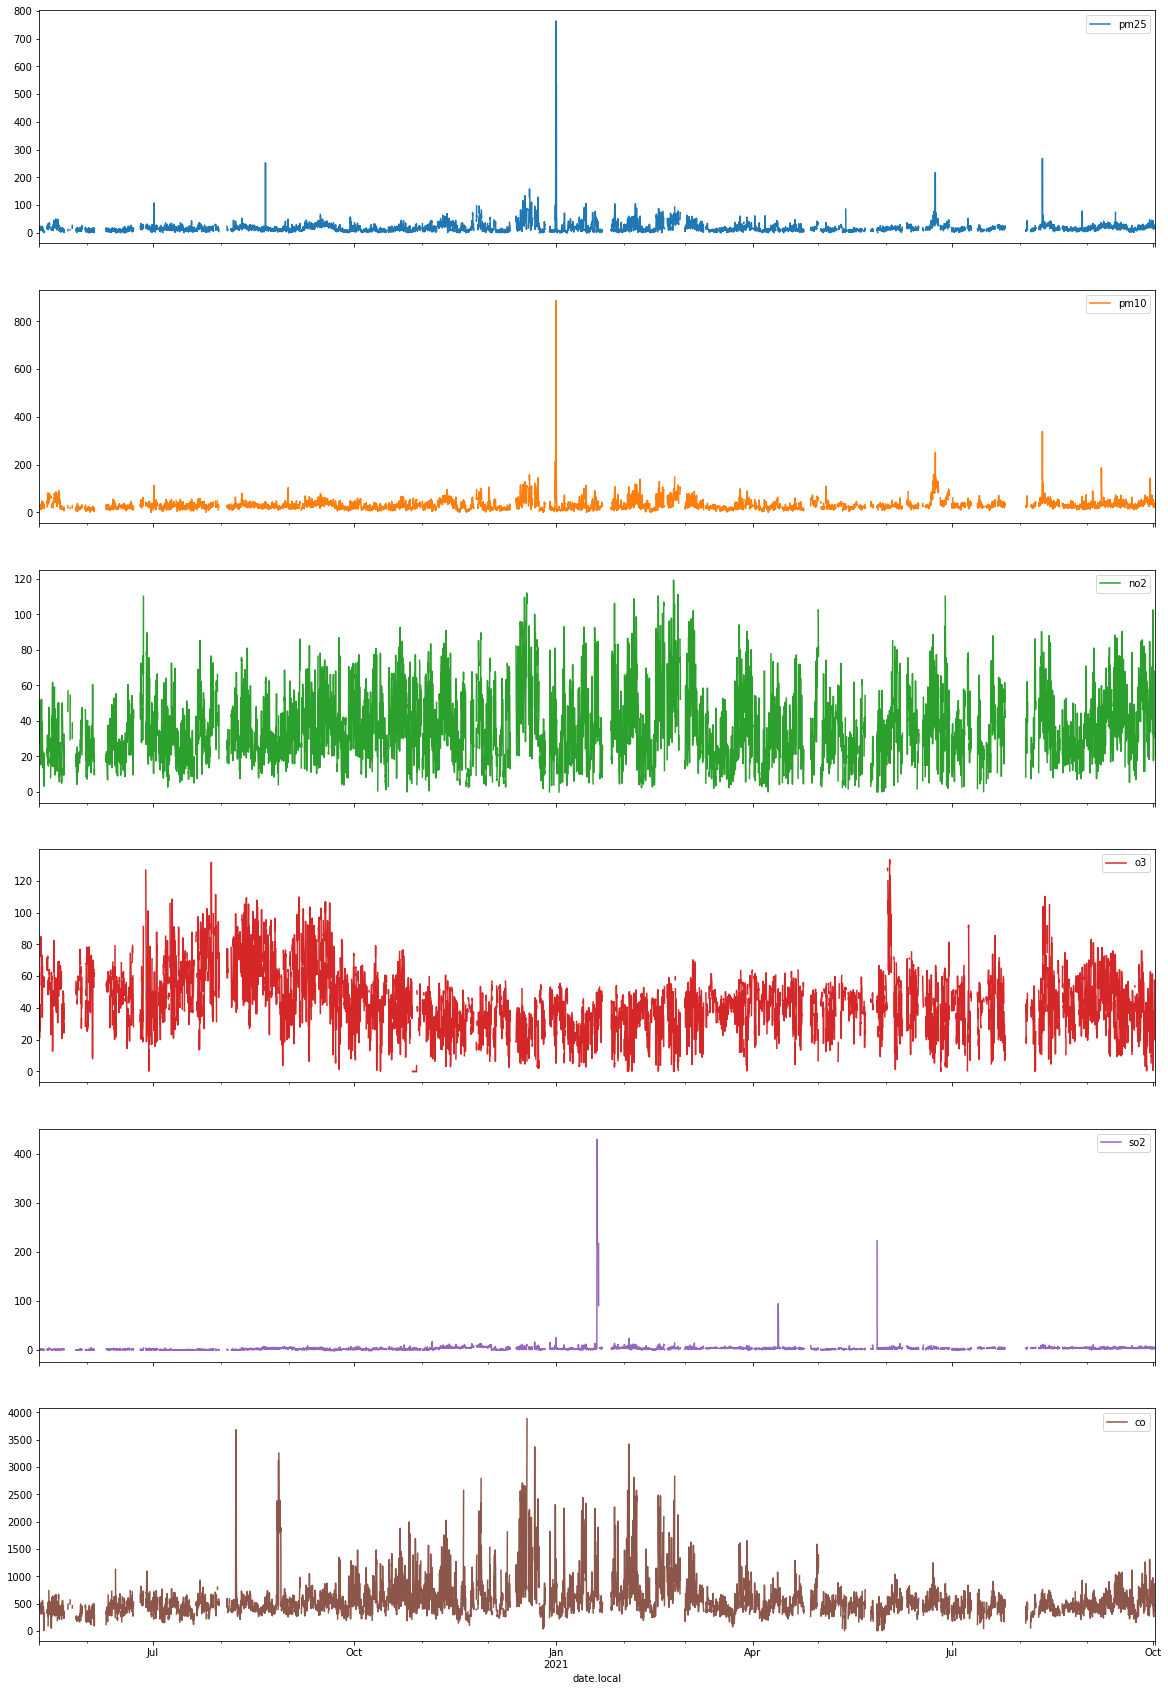

In [4]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [5]:
# Create Point for Napoli
# We will give the median between the maximum: 17m, minimum: 0m elevation of Napoli 

loc = Point(selected_location.lat, selected_location.lon, 9.5)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

pm25       pm10        no2     o3    so2          co  \
2020-05-10 02:00:00  13.60  27.000000  47.531667  61.76  0.605  572.500000   
2020-05-10 03:00:00   9.50  22.833333  51.863333  21.06  0.670  490.000000   
2020-05-10 04:00:00  16.65  22.500000  44.445000  32.12  0.660  480.000000   
2020-05-10 05:00:00  15.30  23.600000  38.851667  25.20  0.360  482.500000   
2020-05-10 06:00:00  18.65  27.066667  31.305000  31.32  0.820  477.500000   
...                    ...        ...        ...    ...    ...         ...   
2021-10-01 20:00:00  22.20  37.900000  54.292000  40.61  5.145  745.000000   
2021-10-01 21:00:00  21.45  33.700000  62.785000  36.11  4.010  866.666667   
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.60  4.180  690.000000   
2021-10-01 23:00:00  21.75  34.200000  63.921667    NaN  3.460  750.000000   
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.29  3.335  650.000000   

                     temp  rhum  wspd    pres  coco  
2020-05-10 02:00:00  17.2  69.4   4.3  1013.7   2.0  
2020-05-10 03:00:00  17.1  67.8   7.9  1013.8   2.0  
2020-05-10 04:00:00  17.4  68.2   3.7  1013.8   2.0  
2020-05-10 05:00:00  17.7  69.9  10.8  1013.0   2.0  
2020-05-10 06:00:00  17.7  69.8  10.0  1013.0   2.0  
...                   ...   ...   ...     ...   ...  
2021-10-01 20:00:00  22.5  68.9   4.0  1020.1   1.0  
2021-10-01 21:00:00  22.0  72.0   3.9  1020.1   1.0  
2021-10-01 22:00:00  21.5  74.2   4.4  1019.7   1.0  
2021-10-01 23:00:00  21.4  74.6   5.3  1019.6   1.0  
2021-10-02 00:00:00  21.3  73.5   4.8  1019.5   1.0  

[12239 rows x 11 columns]

## Fill any empty value

In [6]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        print(col)
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='time', limit_direction='both')
        
final_df.isnull().sum()

pm25
pm10
no2
o3
so2
co


pm25    0
pm10    0
no2     0
o3      0
so2     0
co      0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [7]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

In [8]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

pm25       pm10        no2         o3    so2  \
2020-05-10 02:00:00  13.60  27.000000  47.531667  61.760000  0.605   
2020-05-10 03:00:00   9.50  22.833333  51.863333  21.060000  0.670   
2020-05-10 04:00:00  16.65  22.500000  44.445000  32.120000  0.660   
2020-05-10 05:00:00  15.30  23.600000  38.851667  25.200000  0.360   
2020-05-10 06:00:00  18.65  27.066667  31.305000  31.320000  0.820   
...                    ...        ...        ...        ...    ...   
2021-10-01 20:00:00  22.20  37.900000  54.292000  40.610000  5.145   
2021-10-01 21:00:00  21.45  33.700000  62.785000  36.110000  4.010   
2021-10-01 22:00:00  21.65  40.433333  68.230000  32.600000  4.180   
2021-10-01 23:00:00  21.75  34.200000  63.921667  35.125517  3.460   
2021-10-02 00:00:00  26.55  40.933333  56.923333  20.290000  3.335   

                             co  temp  rhum  wspd    pres  coco  pm25_AQI  \
2020-05-10 02:00:00  572.500000  17.2  69.4   4.3  1013.7   2.0         2   
2020-05-10 03:00:00  490.000000  17.1  67.8   7.9  1013.8   2.0         1   
2020-05-10 04:00:00  480.000000  17.4  68.2   3.7  1013.8   2.0         2   
2020-05-10 05:00:00  482.500000  17.7  69.9  10.8  1013.0   2.0         2   
2020-05-10 06:00:00  477.500000  17.7  69.8  10.0  1013.0   2.0         2   
...                         ...   ...   ...   ...     ...   ...       ...   
2021-10-01 20:00:00  745.000000  22.5  68.9   4.0  1020.1   1.0         3   
2021-10-01 21:00:00  866.666667  22.0  72.0   3.9  1020.1   1.0         3   
2021-10-01 22:00:00  690.000000  21.5  74.2   4.4  1019.7   1.0         3   
2021-10-01 23:00:00  750.000000  21.4  74.6   5.3  1019.6   1.0         3   
2021-10-02 00:00:00  650.000000  21.3  73.5   4.8  1019.5   1.0         4   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  
2020-05-10 02:00:00         2        2       2        1            2  
2020-05-10 03:00:00         2        2       1        1            2  
2020-05-10 04:00:00         2        2       1        1            2  
2020-05-10 05:00:00         2        1       1        1            2  
2020-05-10 06:00:00         2        1       1        1            2  
...                       ...      ...     ...      ...          ...  
2021-10-01 20:00:00         2        2       1        1            3  
2021-10-01 21:00:00         2        2       1        1            3  
2021-10-01 22:00:00         1        2       1        1            3  
2021-10-01 23:00:00         2        2       1        1            3  
2021-10-02 00:00:00         1        2       1        1            4  

[12239 rows x 17 columns]

### Change type of each value for memory performance

In [9]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12239 entries, 2020-05-10 02:00:00 to 2021-10-02 00:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12239 non-null  float32
 1   pm10         12239 non-null  float32
 2   no2          12239 non-null  float32
 3   o3           12239 non-null  float32
 4   so2          12239 non-null  float32
 5   co           12239 non-null  float32
 6   temp         12239 non-null  float32
 7   rhum         12239 non-null  float32
 8   wspd         12239 non-null  float32
 9   pres         12239 non-null  float32
 10  coco         12239 non-null  float32
 11  pm25_AQI     12239 non-null  float32
 12  pm10_AQI     12239 non-null  float32
 13  no2_AQI      12239 non-null  float32
 14  o3_AQI       12239 non-null  float32
 15  so2_AQI      12239 non-null  float32
 16  overall_AQI  12239 non-null  float32
dtypes: float32(17)
memory usage: 908.4 KB


# Data Correlation
Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

Pearson

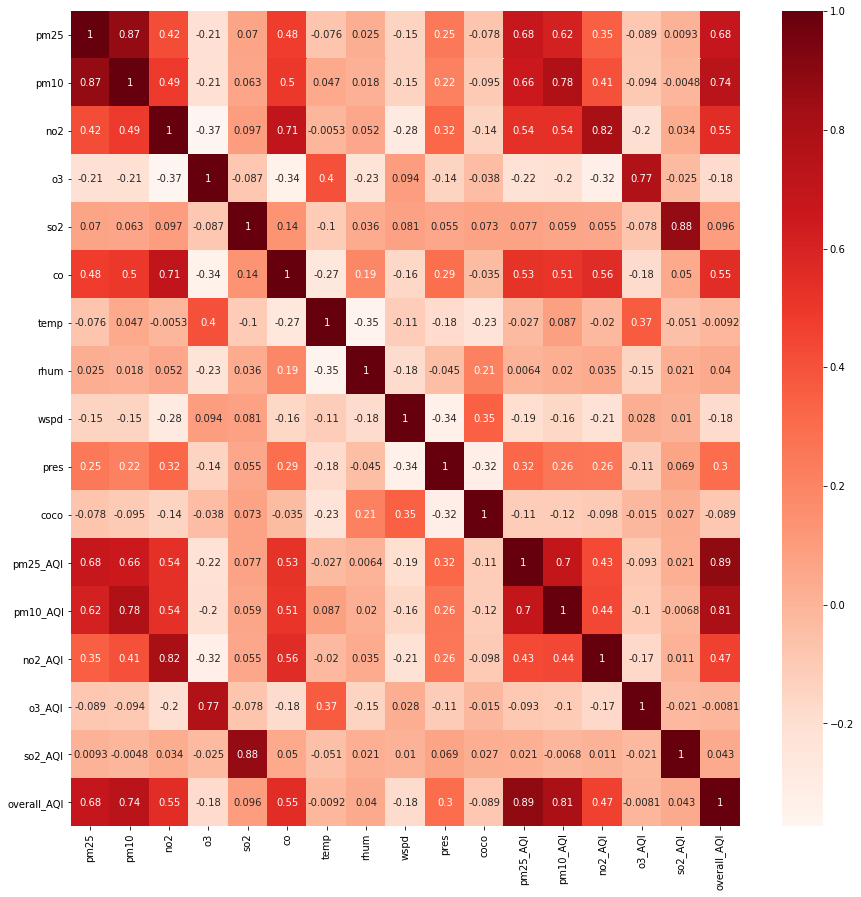

In [10]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

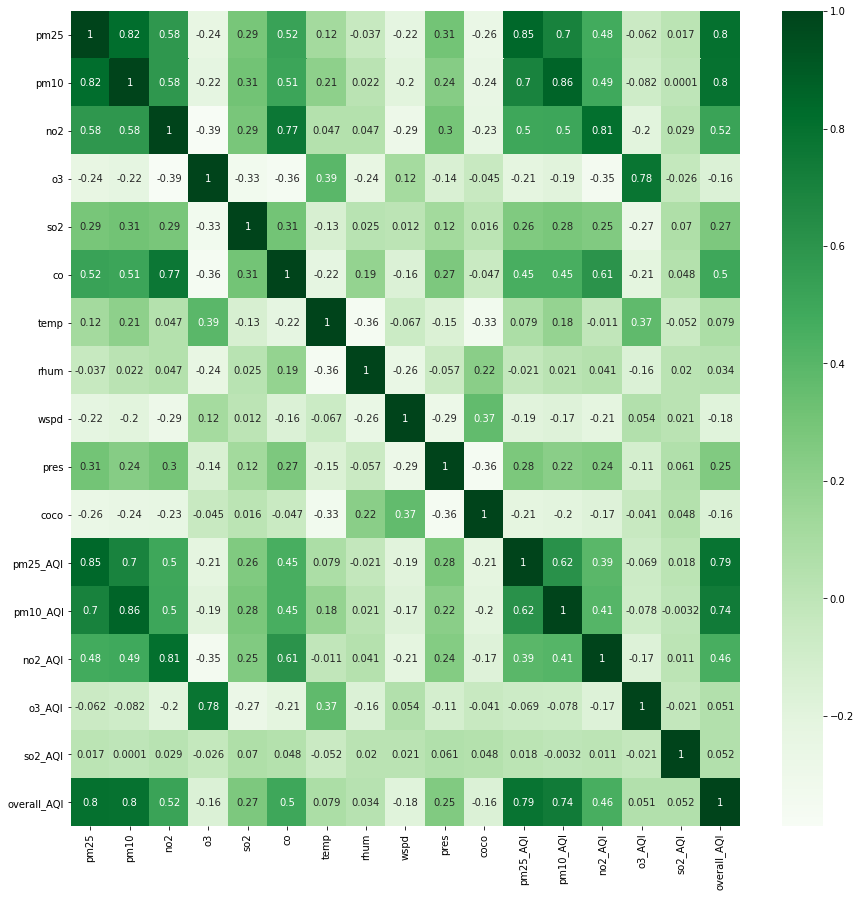

In [11]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's tau

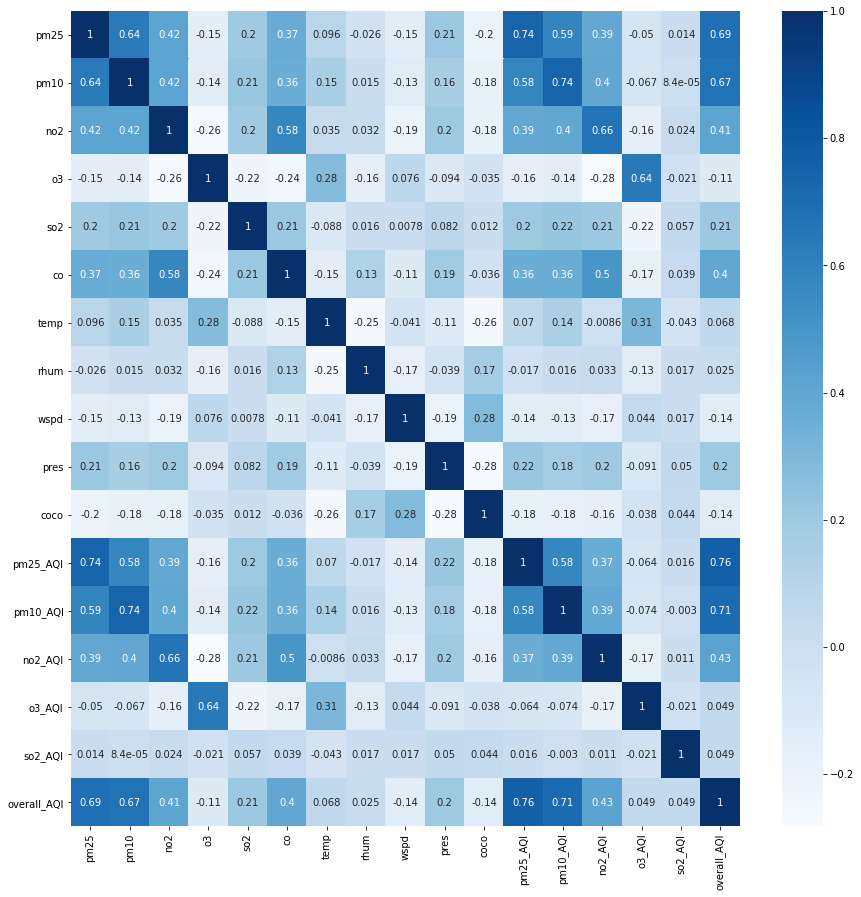

In [12]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [13]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'temp', 'rhum', 'wspd',
       'pres', 'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [14]:
dataset = final_df.copy()
dataset

pm25       pm10        no2         o3    so2  \
2020-05-10 02:00:00  13.600000  27.000000  47.531666  61.759998  0.605   
2020-05-10 03:00:00   9.500000  22.833334  51.863335  21.059999  0.670   
2020-05-10 04:00:00  16.650000  22.500000  44.445000  32.119999  0.660   
2020-05-10 05:00:00  15.300000  23.600000  38.851665  25.200001  0.360   
2020-05-10 06:00:00  18.650000  27.066668  31.305000  31.320000  0.820   
...                        ...        ...        ...        ...    ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000  40.610001  5.145   
2021-10-01 21:00:00  21.450001  33.700001  62.785000  36.110001  4.010   
2021-10-01 22:00:00  21.650000  40.433334  68.230003  32.599998  4.180   
2021-10-01 23:00:00  21.750000  34.200001  63.921665  35.125519  3.460   
2021-10-02 00:00:00  26.549999  40.933334  56.923332  20.290001  3.335   

                             co       temp       rhum  wspd         pres  \
2020-05-10 02:00:00  572.500000  17.200001  69.400002   4.3  1013.700012   
2020-05-10 03:00:00  490.000000  17.100000  67.800003   7.9  1013.799988   
2020-05-10 04:00:00  480.000000  17.400000  68.199997   3.7  1013.799988   
2020-05-10 05:00:00  482.500000  17.700001  69.900002  10.8  1013.000000   
2020-05-10 06:00:00  477.500000  17.700001  69.800003  10.0  1013.000000   
...                         ...        ...        ...   ...          ...   
2021-10-01 20:00:00  745.000000  22.500000  68.900002   4.0  1020.099976   
2021-10-01 21:00:00  866.666687  22.000000  72.000000   3.9  1020.099976   
2021-10-01 22:00:00  690.000000  21.500000  74.199997   4.4  1019.700012   
2021-10-01 23:00:00  750.000000  21.400000  74.599998   5.3  1019.599976   
2021-10-02 00:00:00  650.000000  21.299999  73.500000   4.8  1019.500000   

                     coco  pm25_AQI  pm10_AQI  no2_AQI  o3_AQI  so2_AQI  \
2020-05-10 02:00:00   2.0       2.0       2.0      2.0     2.0      1.0   
2020-05-10 03:00:00   2.0       1.0       2.0      2.0     1.0      1.0   
2020-05-10 04:00:00   2.0       2.0       2.0      2.0     1.0      1.0   
2020-05-10 05:00:00   2.0       2.0       2.0      1.0     1.0      1.0   
2020-05-10 06:00:00   2.0       2.0       2.0      1.0     1.0      1.0   
...                   ...       ...       ...      ...     ...      ...   
2021-10-01 20:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-01 21:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-01 22:00:00   1.0       3.0       1.0      2.0     1.0      1.0   
2021-10-01 23:00:00   1.0       3.0       2.0      2.0     1.0      1.0   
2021-10-02 00:00:00   1.0       4.0       1.0      2.0     1.0      1.0   

                     overall_AQI  
2020-05-10 02:00:00          2.0  
2020-05-10 03:00:00          2.0  
2020-05-10 04:00:00          2.0  
2020-05-10 05:00:00          2.0  
2020-05-10 06:00:00          2.0  
...                          ...  
2021-10-01 20:00:00          3.0  
2021-10-01 21:00:00          3.0  
2021-10-01 22:00:00          3.0  
2021-10-01 23:00:00          3.0  
2021-10-02 00:00:00          4.0  

[12239 rows x 17 columns]

### Split Data

In [15]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9913, 17)
X_test: (1224, 17)


### Normalize Data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9913, 17), (1224, 17))

### Set up data with TimeseriesGenerator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.01780921, 0.03042425, 0.39825442, 0.46328107, 0.00571767,
          0.14522375, 0.48709685, 0.6350185 , 0.0628655 , 0.43961334,
          0.03846154, 0.2       , 0.2       , 0.5       , 0.33333334,
          0.        , 0.2       ],
         [0.01244025, 0.02572915, 0.43454826, 0.15797764, 0.00586844,
          0.12392428, 0.48387104, 0.6152898 , 0.11549708, 0.44202995,
          0.03846154, 0.        , 0.2       , 0.5       , 0.        ,
          0.        , 0.2       ],
         [0.02180318, 0.02535354, 0.37239212, 0.24094217, 0.00584524,
          0.12134252, 0.49354845, 0.6202219 , 0.05409357, 0.44202995,
          0.03846154, 0.2       , 0.2       , 0.5       , 0.        ,
          0.        , 0.2       ],
         [0.02003536, 0.02659305, 0.32552716, 0.18903309, 0.00514938,
          0.12198796, 0.50322586, 0.6411838 , 0.15789475, 0.4227066 ,
          0.03846154, 0.2       , 0.2       , 0.        , 0.        ,
          0.        , 0.2       ],
         [0.02442218

# Create LSTM model

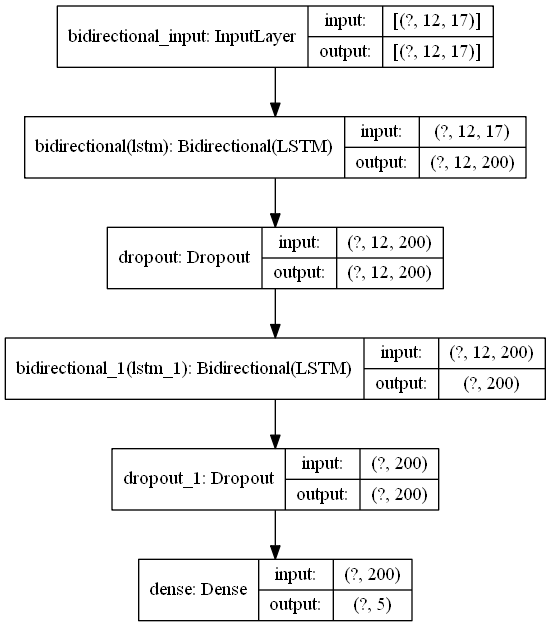

In [18]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

In [19]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=test_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 37s 15ms/step - loss: 0.3596 - val_loss: 0.1570
Epoch 2/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.2333 - val_loss: 0.1978
Epoch 3/200
2476/2476 [==============================] - 36s 15ms/step - loss: 0.2016 - val_loss: 0.1097
Epoch 4/200
2476/2476 [==============================] - 36s 15ms/step - loss: 0.2028 - val_loss: 0.1401
Epoch 5/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.2651 - val_loss: 0.1224
Epoch 6/200
2476/2476 [==============================] - 36s 14ms/step - loss: 0.1948 - val_loss: 0.1149
Epoch 7/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.1886 - val_loss: 0.1065
Epoch 8/200
2476/2476 [==============================] - 36s 14ms/step - loss: 0.1859 - val_loss: 0.1100
Epoch 9/200
2476/2476 [==============================] - 35s 14ms/step - loss: 0.1812 - val_loss: 0.1079
Epoch 10/200
2476/2476 [==============================]

Text(0, 0.5, 'mse score')

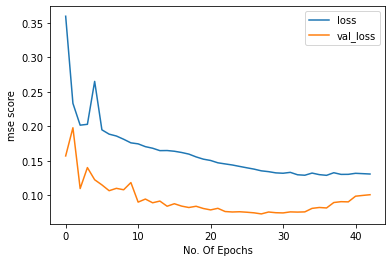

In [20]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [21]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 4ms/step - loss: 0.0728


0.07283513247966766

### Get Predictions

In [22]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     26.222321  46.323116  40.489910  68.083076  3.462451
1     20.319435  37.085587  31.628408  71.591537  3.351115
2     24.493670  44.572407  41.504456  67.608185  3.794289
3     32.925060  56.956802  49.904312  62.886581  4.176180
4     29.880772  52.756893  45.986225  70.875160  4.173767
...         ...        ...        ...        ...       ...
1207  19.076241  34.554016  48.175529  48.980160  3.989480
1208  22.192881  38.323524  53.826473  40.083012  3.962043
1209  26.147293  43.243240  57.813686  33.925861  4.148200
1210  24.479322  40.472359  57.391506  29.910023  4.180175
1211  25.741629  42.003082  56.280781  28.891201  4.199168

[1212 rows x 5 columns]

In [23]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2          o3     so2  \
2021-08-12 13:00:00  18.549999  40.366665  32.875999   70.889999   4.205   
2021-08-12 14:00:00  18.500000  48.266666  47.368332   77.129997   5.940   
2021-08-12 15:00:00  26.150000  81.033333  62.093334   91.529999  10.050   
2021-08-12 16:00:00  28.600000  66.933334  49.701668  110.239998   7.670   
2021-08-12 17:00:00  32.400002  42.799999  37.125999   98.000000   8.330   
...                        ...        ...        ...         ...     ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000   40.610001   5.145   
2021-10-01 21:00:00  21.450001  33.700001  62.785000   36.110001   4.010   
2021-10-01 22:00:00  21.650000  40.433334  68.230003   32.599998   4.180   
2021-10-01 23:00:00  21.750000  34.200001  63.921665   35.125519   3.460   
2021-10-02 00:00:00  26.549999  40.933334  56.923332   20.290001   3.335   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-12 13:00:00  337.500000  34.099998  51.099998  10.0  1016.900024  ...   
2021-08-12 14:00:00  460.000000  34.099998  52.400002   9.3  1016.900024  ...   
2021-08-12 15:00:00  535.000000  33.400002  50.599998  13.0  1016.400024  ...   
2021-08-12 16:00:00  557.500000  32.900002  51.400002  11.3  1016.900024  ...   
2021-08-12 17:00:00  553.333313  32.000000  50.000000   6.9  1016.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  22.500000  68.900002   4.0  1020.099976  ...   
2021-10-01 21:00:00  866.666687  22.000000  72.000000   3.9  1020.099976  ...   
2021-10-01 22:00:00  690.000000  21.500000  74.199997   4.4  1019.700012  ...   
2021-10-01 23:00:00  750.000000  21.400000  74.599998   5.3  1019.599976  ...   
2021-10-02 00:00:00  650.000000  21.299999  73.500000   4.8  1019.500000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-12 13:00:00       1.0      1.0     2.0      1.0          2.0   
2021-08-12 14:00:00       3.0      2.0     2.0      1.0          3.0   
2021-08-12 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-12 16:00:00       4.0      2.0     3.0      1.0          4.0   
2021-08-12 17:00:00       3.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-12 13:00:00  26.222321  46.323116  40.489910  68.083076  3.462451  
2021-08-12 14:00:00  20.319435  37.085587  31.628408  71.591537  3.351115  
2021-08-12 15:00:00  24.493670  44.572407  41.504456  67.608185  3.794289  
2021-08-12 16:00:00  32.925060  56.956802  49.904312  62.886581  4.176180  
2021-08-12 17:00:00  29.880772  52.756893  45.986225  70.875160  4.173767  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  19.076241  34.554016  48.175529  48.980160  3.989480  
2021-10-01 21:00:00  22.192881  38.323524  53.826473  40.083012  3.962043  
2021-10-01 22:00:00  26.147293  43.243240  57.813686  33.925861  4.148200  
2021-10-01 23:00:00  24.479322  40.472359  57.391506  29.910023  4.180175  
2021-10-02 00:00:00  25.741629  42.003082  56.280781  28.891201  4.199168  

[1212 rows x 22 columns]

<AxesSubplot:>

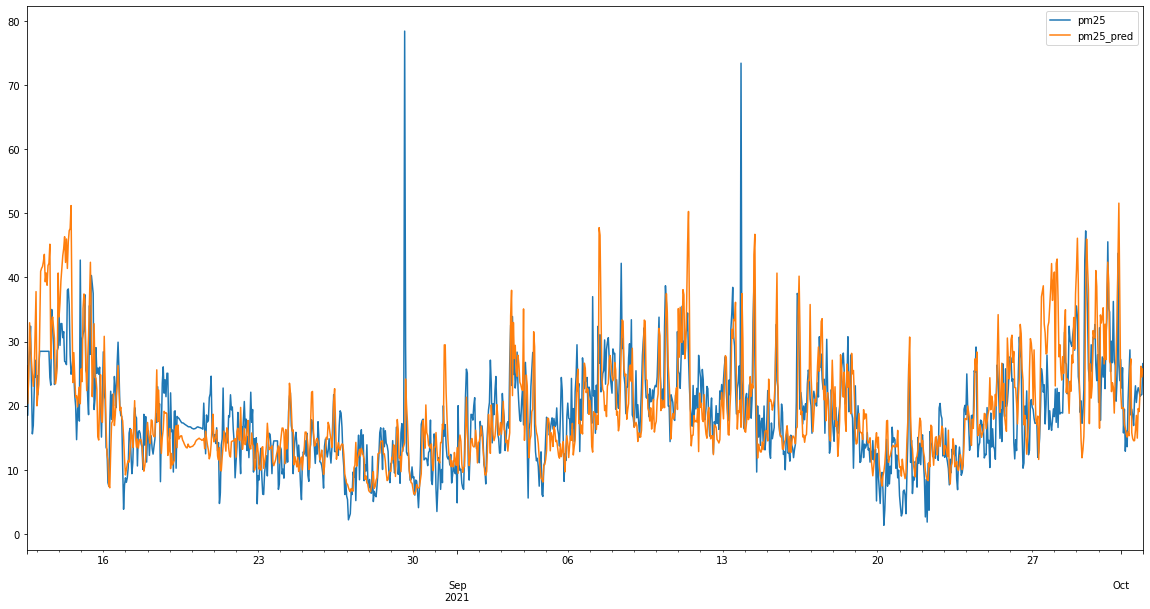

In [24]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

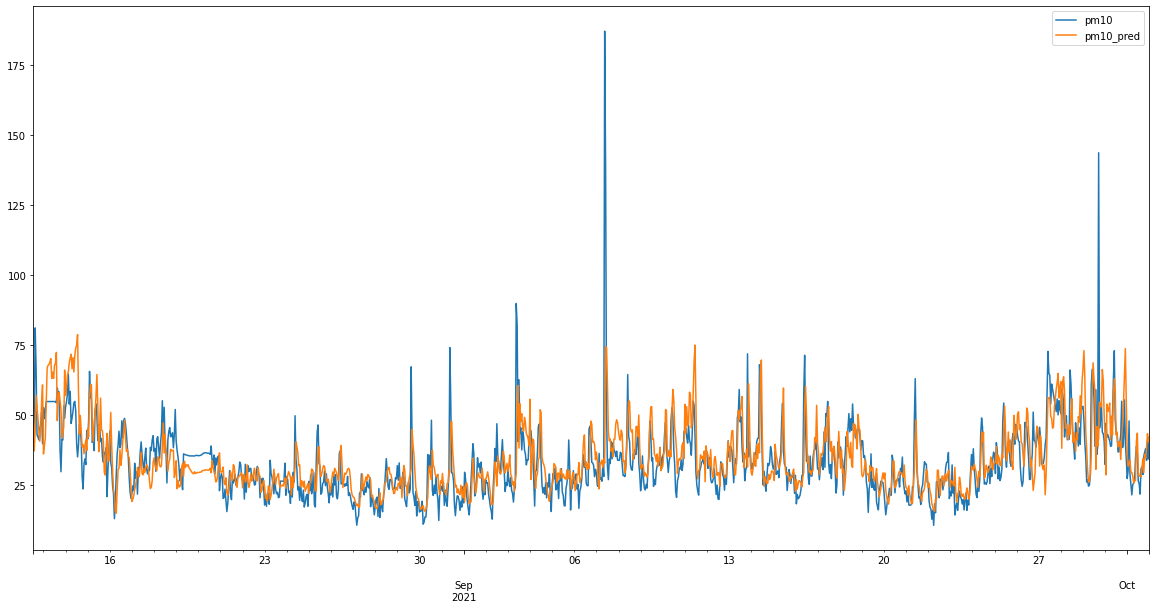

In [25]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

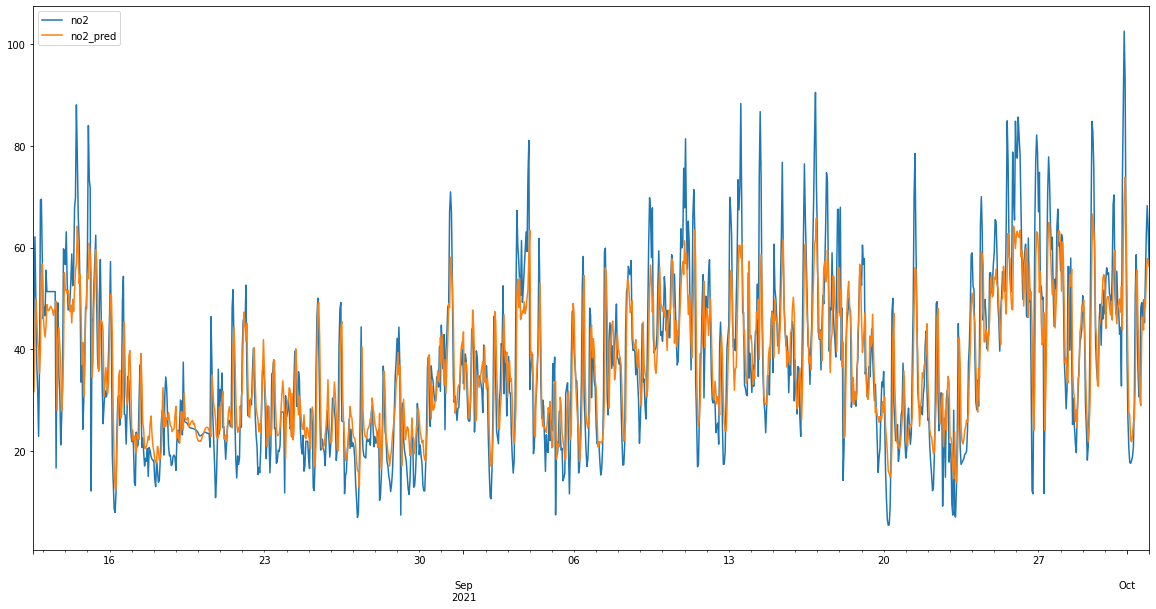

In [26]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

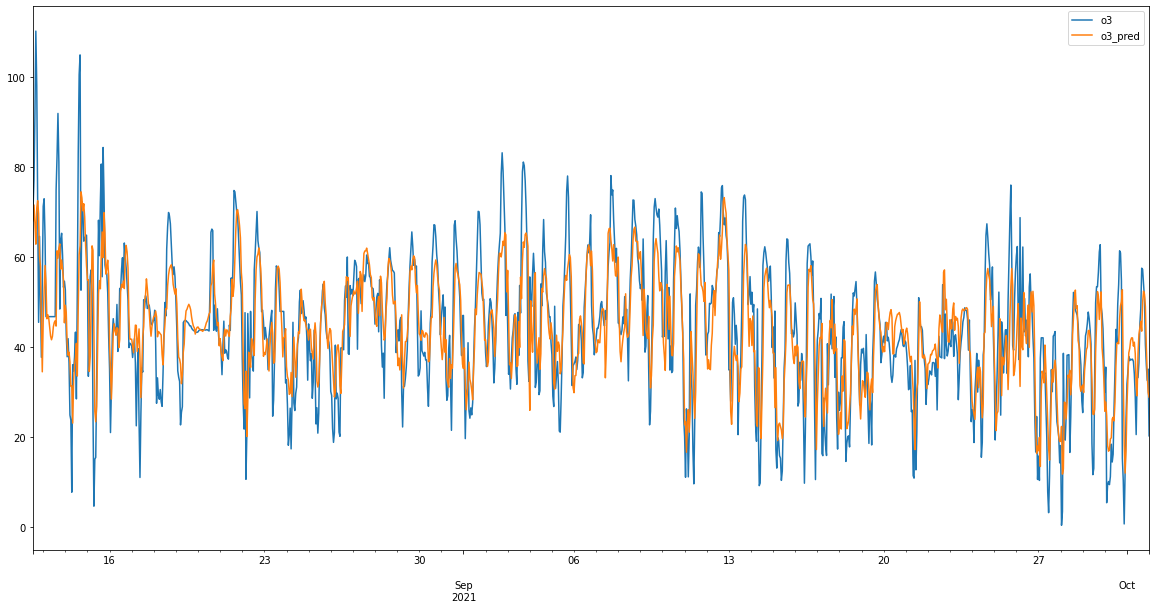

In [27]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

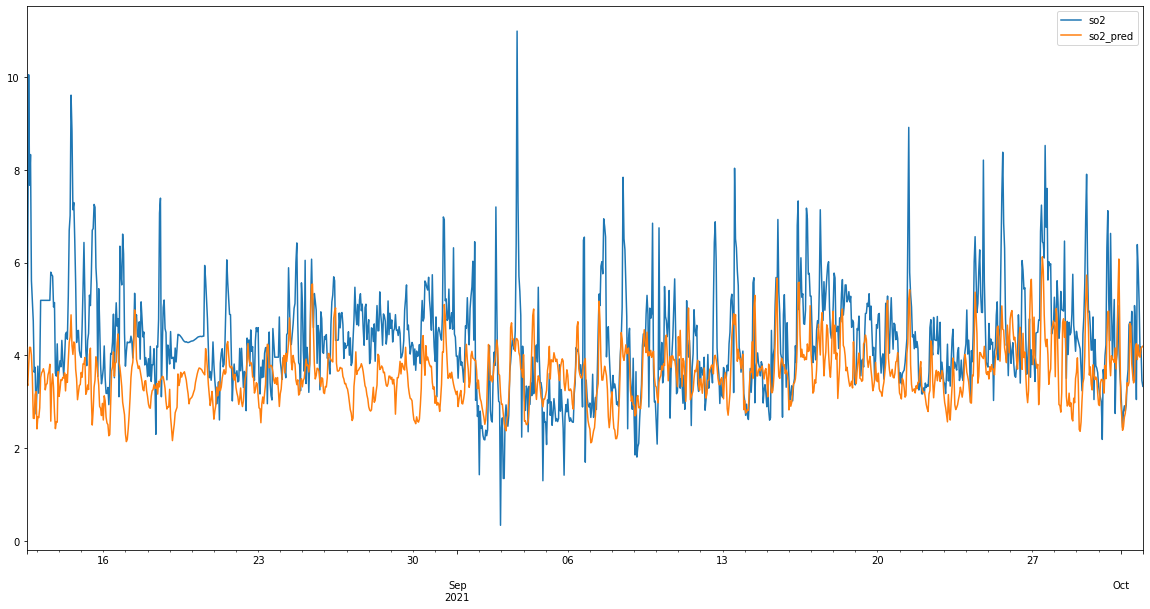

In [28]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Create CNN Model

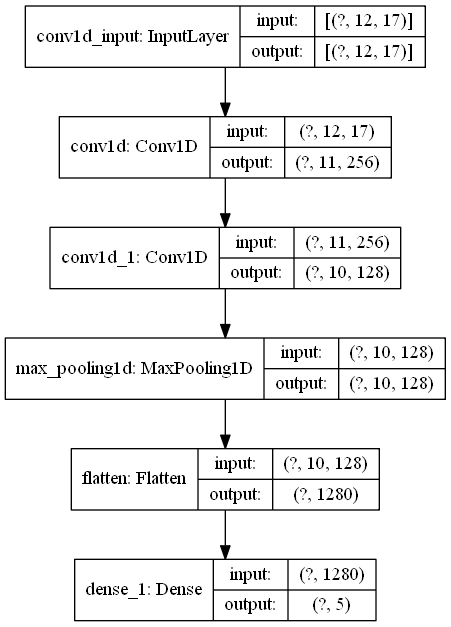

In [29]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

In [30]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=test_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.7706 - val_loss: 0.6896
Epoch 2/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.4207 - val_loss: 0.1226
Epoch 3/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.2670 - val_loss: 0.1110
Epoch 4/400
2476/2476 [==============================] - 11s 4ms/step - loss: 0.2941 - val_loss: 0.1074
Epoch 5/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.2947 - val_loss: 0.1051
Epoch 6/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.2620 - val_loss: 0.1020
Epoch 7/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.2586 - val_loss: 0.1014
Epoch 8/400
2476/2476 [==============================] - 11s 5ms/step - loss: 0.1220 - val_loss: 0.1095
Epoch 9/400
2476/2476 [==============================] - 10s 4ms/step - loss: 0.1221 - val_loss: 0.1021
Epoch 10/400
2476/2476 [==============================] - 10s 4m

Text(0, 0.5, 'mse score')

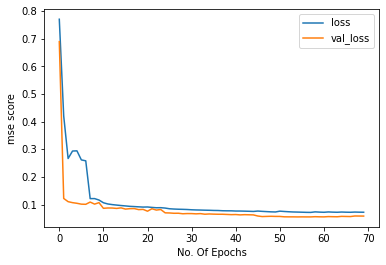

In [31]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [32]:
model_CNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 2ms/step - loss: 0.0558


0.055849894881248474

### Get Predictions

In [33]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     26.980341  43.684448  37.585087  64.353317  4.767426
1     25.401634  38.982502  30.721916  72.630737  5.423662
2     27.365606  50.689850  47.905186  71.533310  6.769234
3     34.137856  65.587990  58.672810  77.844925  7.347572
4     30.883663  60.521912  48.762848  95.723373  6.590978
...         ...        ...        ...        ...       ...
1207  22.807322  35.632484  48.315159  46.108311  4.424755
1208  23.648598  36.839783  54.797626  40.540207  4.471115
1209  23.038372  37.085171  58.966518  36.215618  4.404301
1210  24.700468  37.392654  62.450775  32.340191  4.413092
1211  23.062027  35.973740  54.509953  33.428432  3.866548

[1212 rows x 5 columns]

In [34]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2          o3     so2  \
2021-08-12 13:00:00  18.549999  40.366665  32.875999   70.889999   4.205   
2021-08-12 14:00:00  18.500000  48.266666  47.368332   77.129997   5.940   
2021-08-12 15:00:00  26.150000  81.033333  62.093334   91.529999  10.050   
2021-08-12 16:00:00  28.600000  66.933334  49.701668  110.239998   7.670   
2021-08-12 17:00:00  32.400002  42.799999  37.125999   98.000000   8.330   
...                        ...        ...        ...         ...     ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000   40.610001   5.145   
2021-10-01 21:00:00  21.450001  33.700001  62.785000   36.110001   4.010   
2021-10-01 22:00:00  21.650000  40.433334  68.230003   32.599998   4.180   
2021-10-01 23:00:00  21.750000  34.200001  63.921665   35.125519   3.460   
2021-10-02 00:00:00  26.549999  40.933334  56.923332   20.290001   3.335   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-12 13:00:00  337.500000  34.099998  51.099998  10.0  1016.900024  ...   
2021-08-12 14:00:00  460.000000  34.099998  52.400002   9.3  1016.900024  ...   
2021-08-12 15:00:00  535.000000  33.400002  50.599998  13.0  1016.400024  ...   
2021-08-12 16:00:00  557.500000  32.900002  51.400002  11.3  1016.900024  ...   
2021-08-12 17:00:00  553.333313  32.000000  50.000000   6.9  1016.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  22.500000  68.900002   4.0  1020.099976  ...   
2021-10-01 21:00:00  866.666687  22.000000  72.000000   3.9  1020.099976  ...   
2021-10-01 22:00:00  690.000000  21.500000  74.199997   4.4  1019.700012  ...   
2021-10-01 23:00:00  750.000000  21.400000  74.599998   5.3  1019.599976  ...   
2021-10-02 00:00:00  650.000000  21.299999  73.500000   4.8  1019.500000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-12 13:00:00       1.0      1.0     2.0      1.0          2.0   
2021-08-12 14:00:00       3.0      2.0     2.0      1.0          3.0   
2021-08-12 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-12 16:00:00       4.0      2.0     3.0      1.0          4.0   
2021-08-12 17:00:00       3.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-12 13:00:00  26.980341  43.684448  37.585087  64.353317  4.767426  
2021-08-12 14:00:00  25.401634  38.982502  30.721916  72.630737  5.423662  
2021-08-12 15:00:00  27.365606  50.689850  47.905186  71.533310  6.769234  
2021-08-12 16:00:00  34.137856  65.587990  58.672810  77.844925  7.347572  
2021-08-12 17:00:00  30.883663  60.521912  48.762848  95.723373  6.590978  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  22.807322  35.632484  48.315159  46.108311  4.424755  
2021-10-01 21:00:00  23.648598  36.839783  54.797626  40.540207  4.471115  
2021-10-01 22:00:00  23.038372  37.085171  58.966518  36.215618  4.404301  
2021-10-01 23:00:00  24.700468  37.392654  62.450775  32.340191  4.413092  
2021-10-02 00:00:00  23.062027  35.973740  54.509953  33.428432  3.866548  

[1212 rows x 22 columns]

<AxesSubplot:>

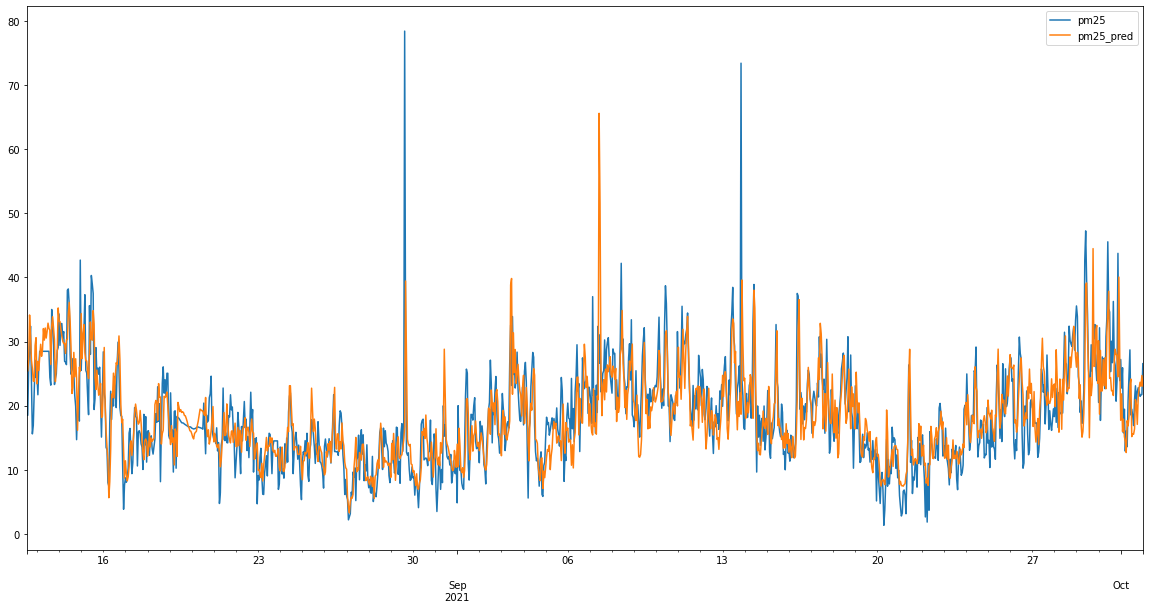

In [35]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

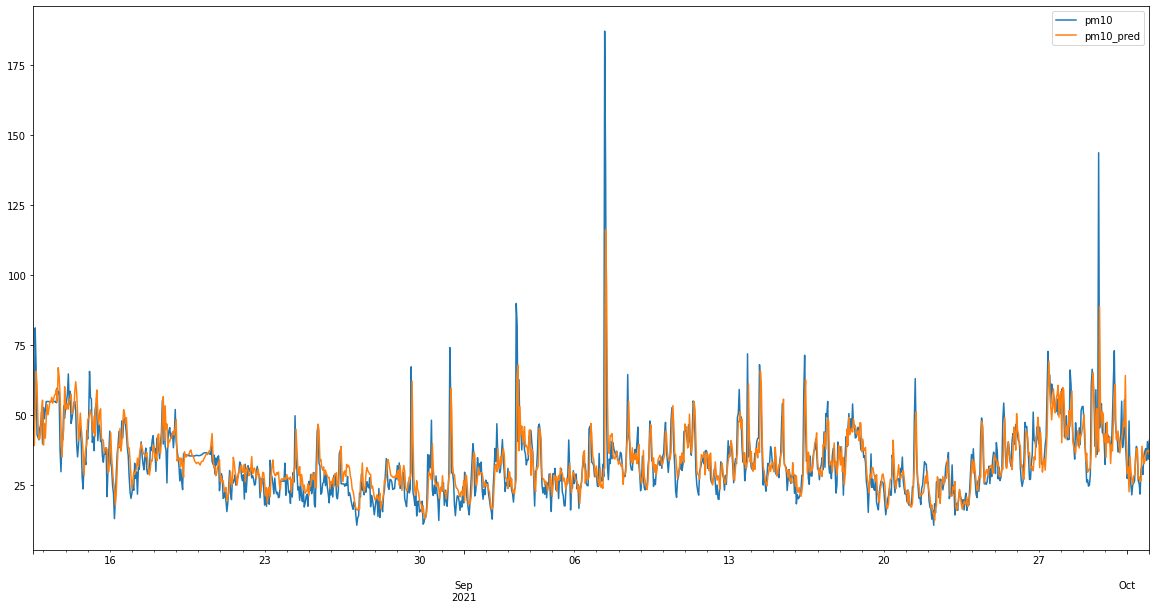

In [36]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

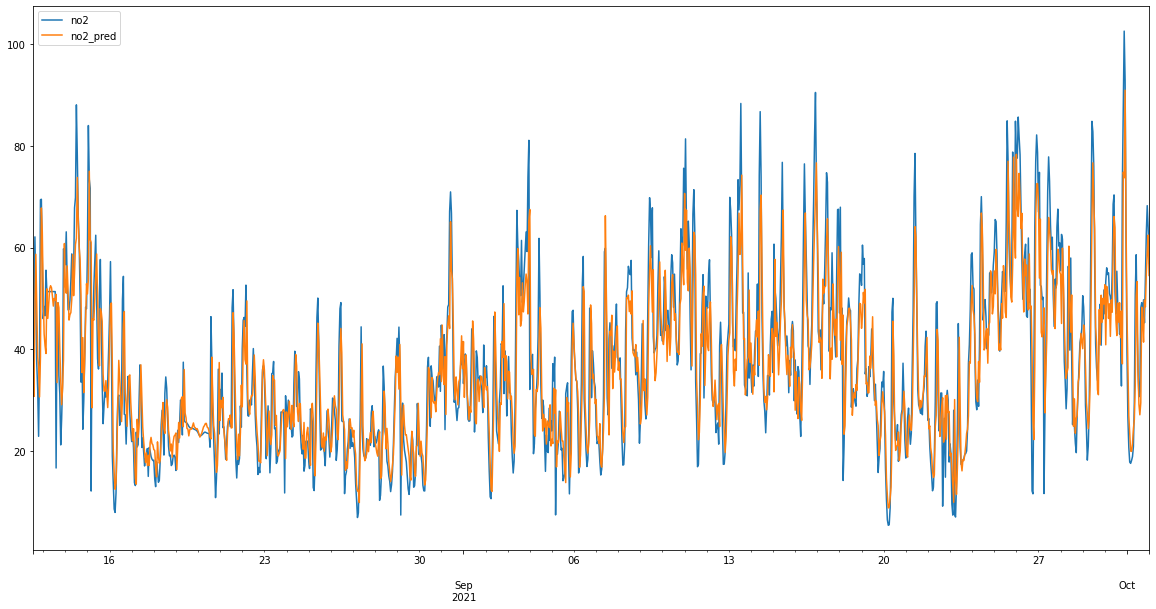

In [37]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

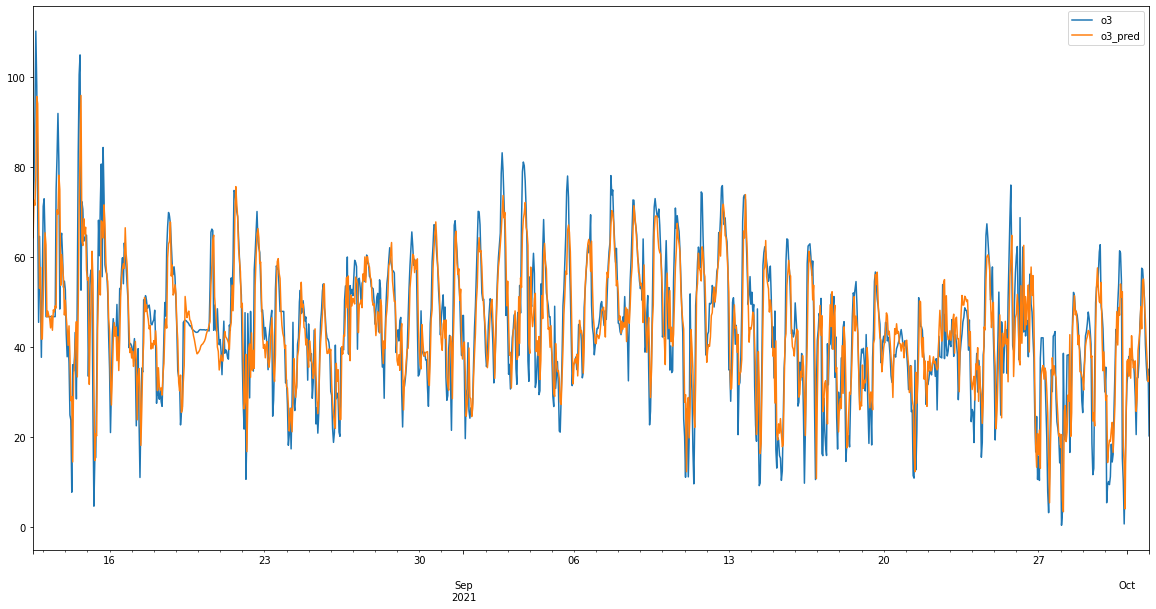

In [38]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

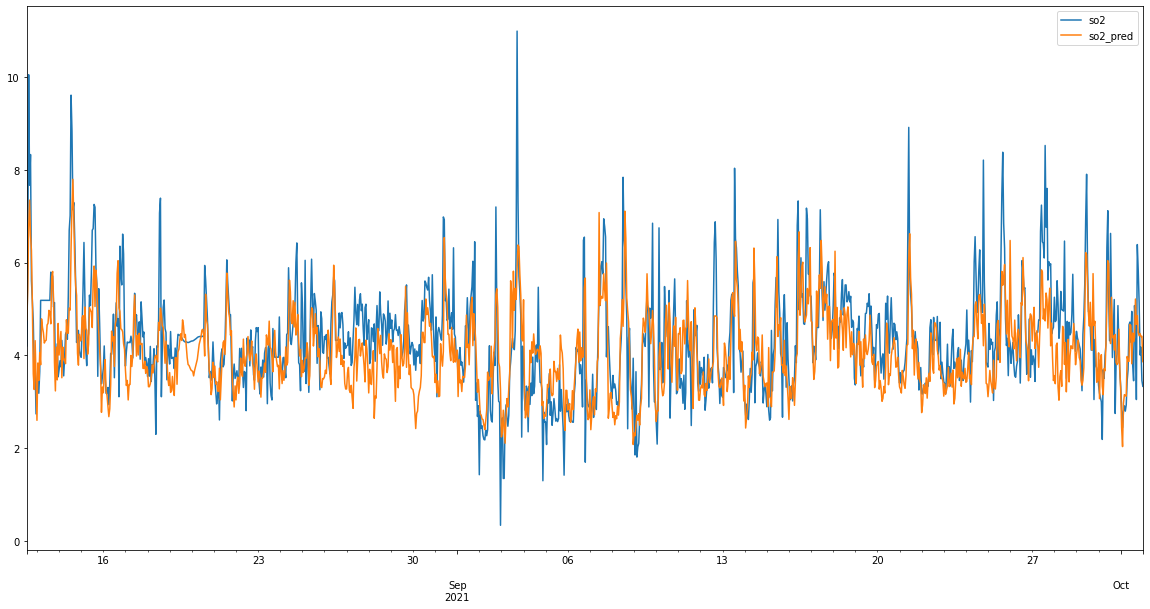

In [39]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# LSTM-CNN Model

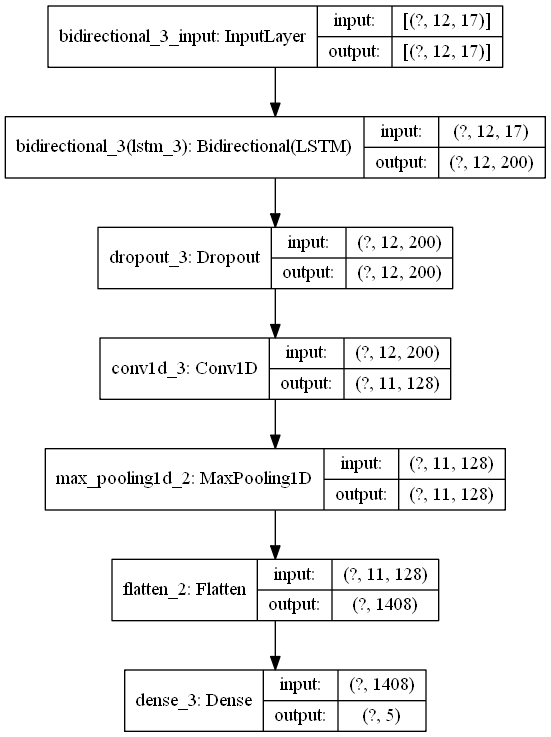

In [77]:
model_LSTMCNN = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTMCNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTMCNN, show_shapes=True)

In [78]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_LSTMCNN = model_LSTMCNN.fit(train_generator, 
                                       validation_data=test_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.6000 - val_loss: 0.1343
Epoch 2/200
2476/2476 [==============================] - 21s 9ms/step - loss: 0.3966 - val_loss: 0.1347
Epoch 3/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.4500 - val_loss: 0.1118
Epoch 4/200
2476/2476 [==============================] - 21s 9ms/step - loss: 0.3800 - val_loss: 0.1092
Epoch 5/200
2476/2476 [==============================] - 21s 9ms/step - loss: 0.3756 - val_loss: 0.1070
Epoch 6/200
2476/2476 [==============================] - 21s 9ms/step - loss: 0.1838 - val_loss: 0.1029
Epoch 7/200
2476/2476 [==============================] - 22s 9ms/step - loss: 0.1740 - val_loss: 0.0968
Epoch 8/200
2476/2476 [==============================] - 21s 8ms/step - loss: 0.1597 - val_loss: 0.0951
Epoch 9/200
2476/2476 [==============================] - 21s 9ms/step - loss: 0.1433 - val_loss: 0.0944
Epoch 10/200
2476/2476 [==============================] - 21s 9m

Text(0, 0.5, 'mse score')

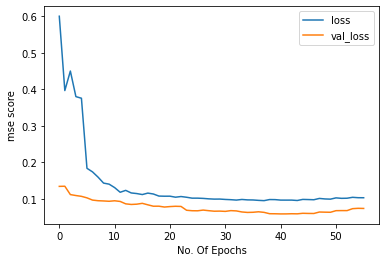

In [79]:
plt.plot(prepared_model_LSTMCNN.history["loss"],label="loss")
plt.plot(prepared_model_LSTMCNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [80]:
model_LSTMCNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 3ms/step - loss: 0.0589


0.05891884118318558

### Get Predictions

In [81]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

0          1          2          3         4
0     26.980341  43.684448  37.585087  64.353317  4.767426
1     25.401634  38.982502  30.721916  72.630737  5.423662
2     27.365606  50.689850  47.905186  71.533310  6.769234
3     34.137856  65.587990  58.672810  77.844925  7.347572
4     30.883663  60.521912  48.762848  95.723373  6.590978
...         ...        ...        ...        ...       ...
1207  22.807322  35.632484  48.315159  46.108311  4.424755
1208  23.648598  36.839783  54.797626  40.540207  4.471115
1209  23.038372  37.085171  58.966518  36.215618  4.404301
1210  24.700468  37.392654  62.450775  32.340191  4.413092
1211  23.062027  35.973740  54.509953  33.428432  3.866548

[1212 rows x 5 columns]

In [82]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pm25       pm10        no2          o3     so2  \
2021-08-12 13:00:00  18.549999  40.366665  32.875999   70.889999   4.205   
2021-08-12 14:00:00  18.500000  48.266666  47.368332   77.129997   5.940   
2021-08-12 15:00:00  26.150000  81.033333  62.093334   91.529999  10.050   
2021-08-12 16:00:00  28.600000  66.933334  49.701668  110.239998   7.670   
2021-08-12 17:00:00  32.400002  42.799999  37.125999   98.000000   8.330   
...                        ...        ...        ...         ...     ...   
2021-10-01 20:00:00  22.200001  37.900002  54.292000   40.610001   5.145   
2021-10-01 21:00:00  21.450001  33.700001  62.785000   36.110001   4.010   
2021-10-01 22:00:00  21.650000  40.433334  68.230003   32.599998   4.180   
2021-10-01 23:00:00  21.750000  34.200001  63.921665   35.125519   3.460   
2021-10-02 00:00:00  26.549999  40.933334  56.923332   20.290001   3.335   

                             co       temp       rhum  wspd         pres  ...  \
2021-08-12 13:00:00  337.500000  34.099998  51.099998  10.0  1016.900024  ...   
2021-08-12 14:00:00  460.000000  34.099998  52.400002   9.3  1016.900024  ...   
2021-08-12 15:00:00  535.000000  33.400002  50.599998  13.0  1016.400024  ...   
2021-08-12 16:00:00  557.500000  32.900002  51.400002  11.3  1016.900024  ...   
2021-08-12 17:00:00  553.333313  32.000000  50.000000   6.9  1016.900024  ...   
...                         ...        ...        ...   ...          ...  ...   
2021-10-01 20:00:00  745.000000  22.500000  68.900002   4.0  1020.099976  ...   
2021-10-01 21:00:00  866.666687  22.000000  72.000000   3.9  1020.099976  ...   
2021-10-01 22:00:00  690.000000  21.500000  74.199997   4.4  1019.700012  ...   
2021-10-01 23:00:00  750.000000  21.400000  74.599998   5.3  1019.599976  ...   
2021-10-02 00:00:00  650.000000  21.299999  73.500000   4.8  1019.500000  ...   

                     pm10_AQI  no2_AQI  o3_AQI  so2_AQI  overall_AQI  \
2021-08-12 13:00:00       1.0      1.0     2.0      1.0          2.0   
2021-08-12 14:00:00       3.0      2.0     2.0      1.0          3.0   
2021-08-12 15:00:00       4.0      2.0     2.0      1.0          4.0   
2021-08-12 16:00:00       4.0      2.0     3.0      1.0          4.0   
2021-08-12 17:00:00       3.0      1.0     2.0      1.0          4.0   
...                       ...      ...     ...      ...          ...   
2021-10-01 20:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 21:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-01 22:00:00       1.0      2.0     1.0      1.0          3.0   
2021-10-01 23:00:00       2.0      2.0     1.0      1.0          3.0   
2021-10-02 00:00:00       1.0      2.0     1.0      1.0          4.0   

                     pm25_pred  pm10_pred   no2_pred    o3_pred  so2_pred  
2021-08-12 13:00:00  26.980341  43.684448  37.585087  64.353317  4.767426  
2021-08-12 14:00:00  25.401634  38.982502  30.721916  72.630737  5.423662  
2021-08-12 15:00:00  27.365606  50.689850  47.905186  71.533310  6.769234  
2021-08-12 16:00:00  34.137856  65.587990  58.672810  77.844925  7.347572  
2021-08-12 17:00:00  30.883663  60.521912  48.762848  95.723373  6.590978  
...                        ...        ...        ...        ...       ...  
2021-10-01 20:00:00  22.807322  35.632484  48.315159  46.108311  4.424755  
2021-10-01 21:00:00  23.648598  36.839783  54.797626  40.540207  4.471115  
2021-10-01 22:00:00  23.038372  37.085171  58.966518  36.215618  4.404301  
2021-10-01 23:00:00  24.700468  37.392654  62.450775  32.340191  4.413092  
2021-10-02 00:00:00  23.062027  35.973740  54.509953  33.428432  3.866548  

[1212 rows x 22 columns]

<AxesSubplot:>

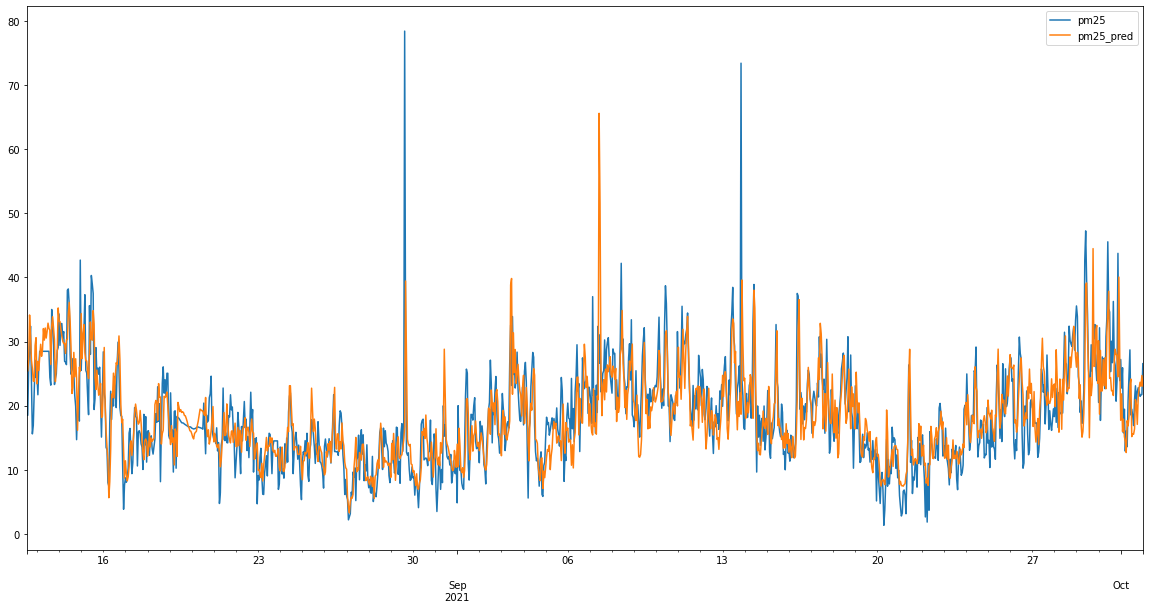

In [83]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

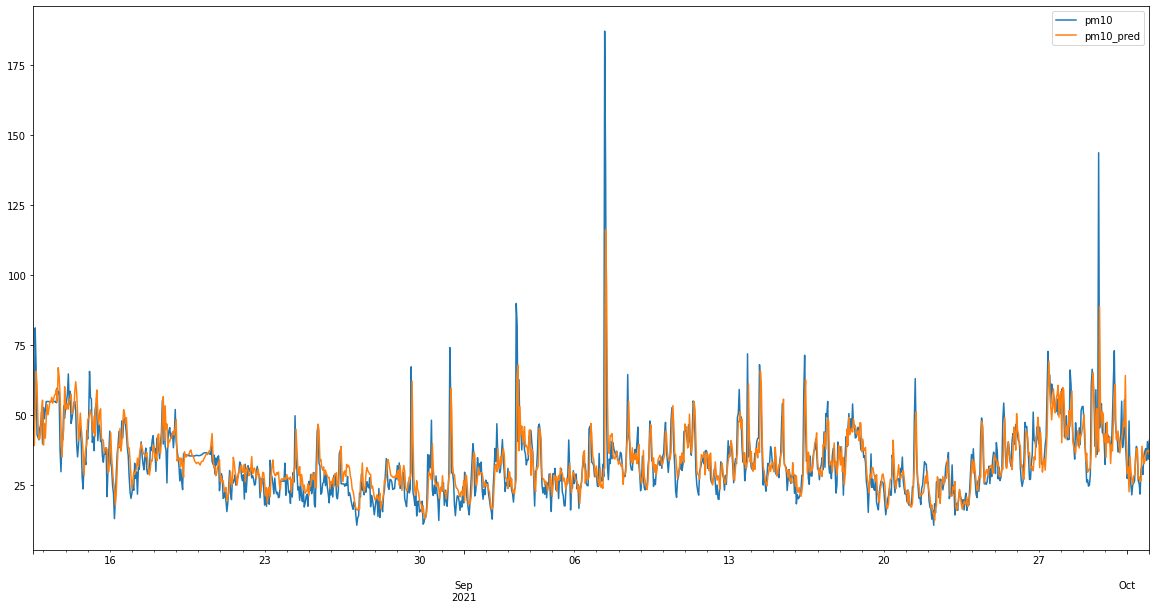

In [84]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

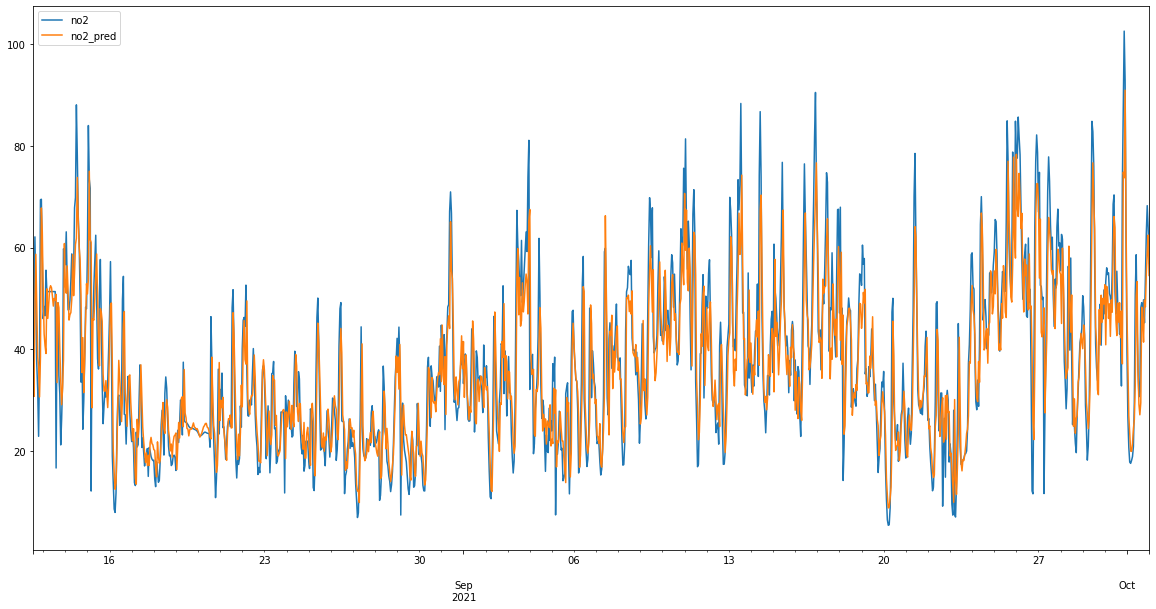

In [85]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

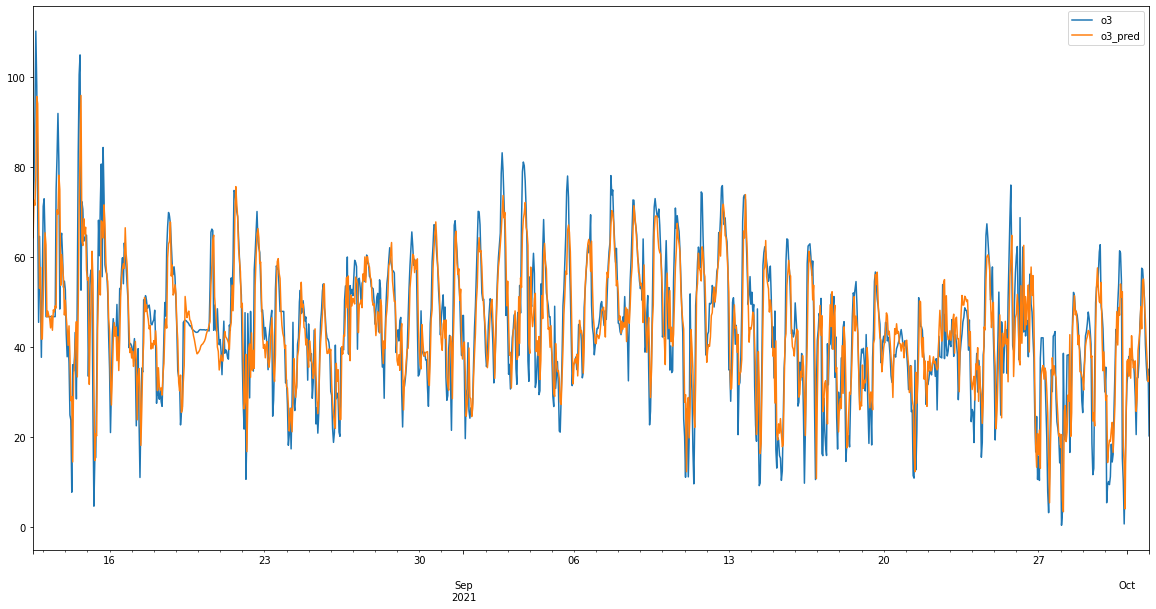

In [86]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

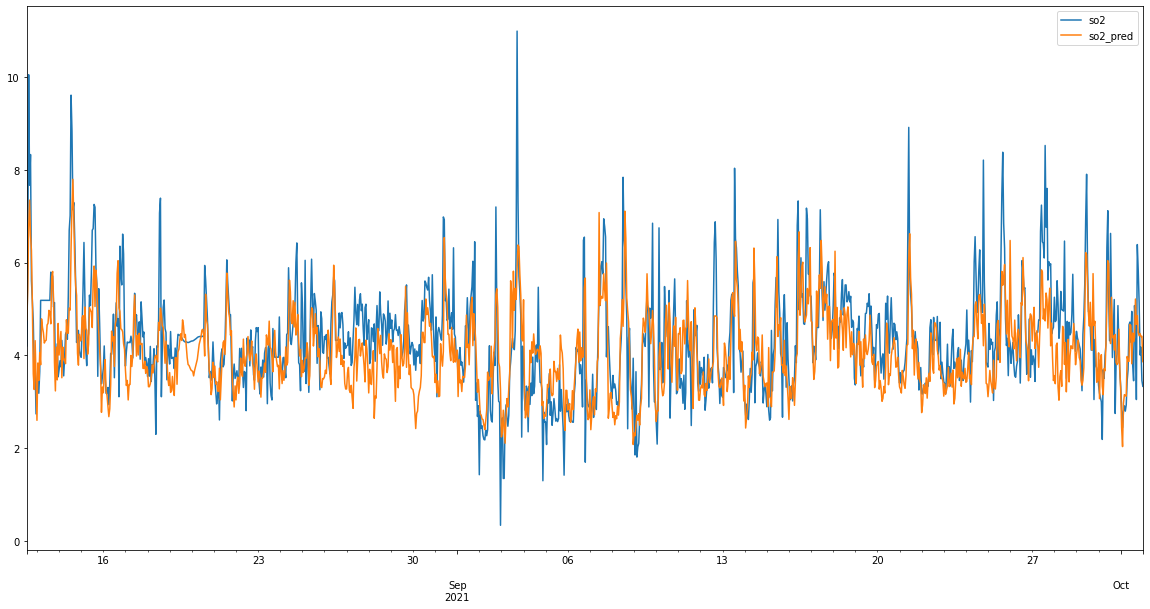

In [87]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [88]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [89]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 3.6510086, 'mse': 28.139896, 'rmse': 5.304705, 'mape': 23.644464, 'mslr': 0.071643144}
-----pm10-----
{'mae': 5.2307005, 'mse': 83.050865, 'rmse': 9.113225, 'mape': 16.354454, 'mslr': 0.043725654}
-----no2-----
{'mae': 6.116702, 'mse': 72.84993, 'rmse': 8.535217, 'mape': 19.568535, 'mslr': 0.06022855}
-----o3-----
{'mae': 6.225123, 'mse': 72.75353, 'rmse': 8.529568, 'mape': 24.71714, 'mslr': 0.07700322}
-----so2-----
{'mae': 0.6450681, 'mse': 0.76104826, 'rmse': 0.8723808, 'mape': 15.812355, 'mslr': 0.026649047}
